In [1]:
%matplotlib inline


# Visualizing cross-validation behavior in scikit-learn

Choosing the right cross-validation object is a crucial part of fitting a
model properly. There are many ways to split data into training and test
sets in order to avoid model overfitting, to standardize the number of
groups in test sets, etc.

This example visualizes the behavior of several common scikit-learn objects
for comparison.


In [2]:
from sklearn.model_selection import (
    TimeSeriesSplit,
    KFold,
    ShuffleSplit,
    StratifiedKFold,
    GroupShuffleSplit,
    GroupKFold,
    StratifiedShuffleSplit,
    StratifiedGroupKFold,
)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

rng = np.random.RandomState(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 4

## Visualize our data

First, we must understand the structure of our data. It has 100 randomly
generated input datapoints, 3 classes split unevenly across datapoints,
and 10 "groups" split evenly across datapoints.

As we'll see, some cross-validation objects do specific things with
labeled data, others behave differently with grouped data, and others
do not use this information.

To begin, we'll visualize our data.



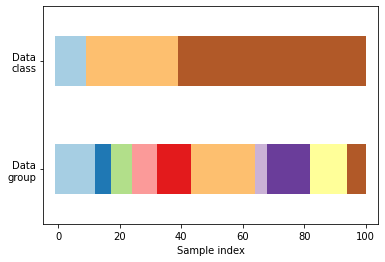

In [3]:
# Generate the class/group data
n_points = 100
X = rng.randn(100, 10)

percentiles_classes = [0.1, 0.3, 0.6]
y = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

# Generate uneven groups
group_prior = rng.dirichlet([2] * 10)
groups = np.repeat(np.arange(10), rng.multinomial(100, group_prior))


def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )


visualize_groups(y, groups, "no groups")

## Define a function to visualize cross-validation behavior

We'll define a function that lets us visualize the behavior of each
cross-validation object. We'll perform 4 splits of the data. On each
split, we'll visualize the indices chosen for the training set
(in blue) and the test set (in red).



In [4]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

Let's see how it looks for the :class:`~sklearn.model_selection.KFold`
cross-validation object:



<AxesSubplot:title={'center':'KFold'}, xlabel='Sample index', ylabel='CV iteration'>

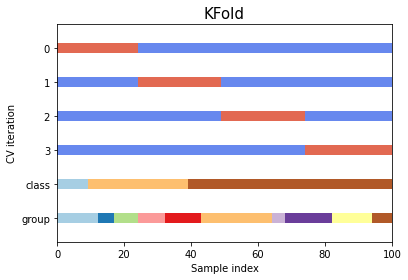

In [5]:
fig, ax = plt.subplots()
cv = KFold(n_splits)
plot_cv_indices(cv, X, y, groups, ax, n_splits)

As you can see, by default the KFold cross-validation iterator does not
take either datapoint class or group into consideration. We can change this
by using either:

- ``StratifiedKFold`` to preserve the percentage of samples for each class.
- ``GroupKFold`` to ensure that the same group will not appear in two
  different folds.
- ``StratifiedGroupKFold`` to keep the constraint of ``GroupKFold`` while
  attempting to return stratified folds.



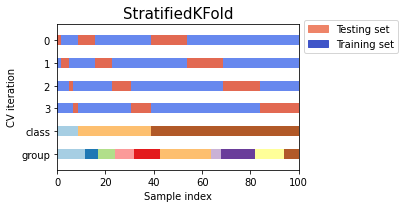

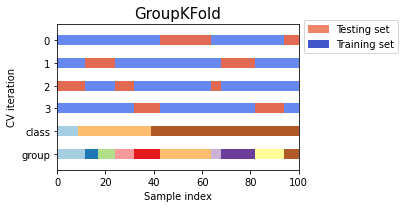

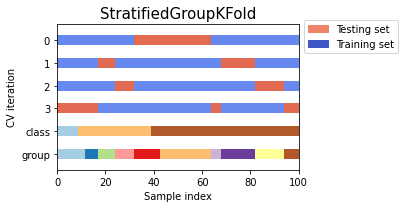

In [6]:
cvs = [StratifiedKFold, GroupKFold, StratifiedGroupKFold]

for cv in cvs:
    fig, ax = plt.subplots(figsize=(6, 3))
    plot_cv_indices(cv(n_splits), X, y, groups, ax, n_splits)
    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    # Make the legend fit
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)

Next we'll visualize this behavior for a number of CV iterators.

## Visualize cross-validation indices for many CV objects

Let's visually compare the cross validation behavior for many
scikit-learn cross-validation objects. Below we will loop through several
common cross-validation objects, visualizing the behavior of each.

Note how some use the group/class information while others do not.



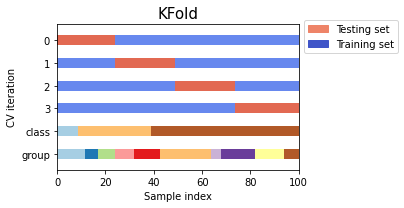

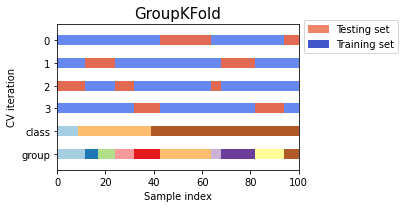

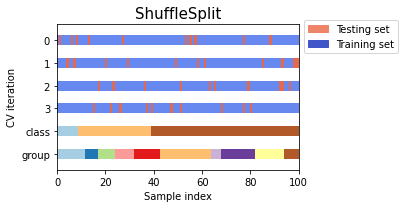

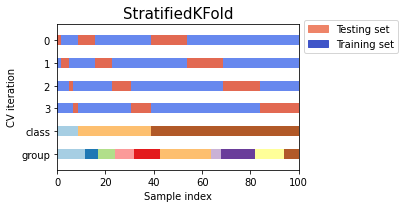

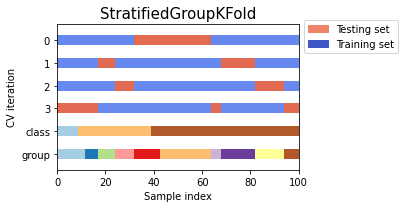

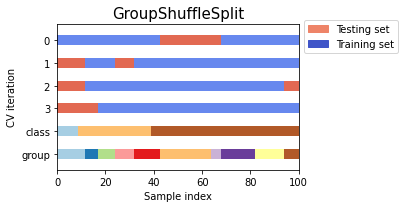

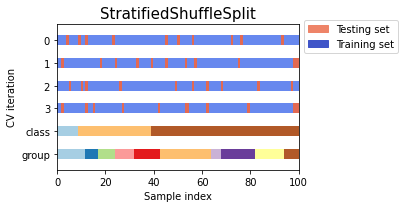

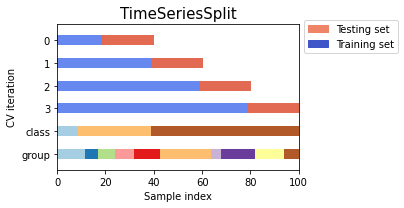

In [7]:
cvs = [
    KFold,
    GroupKFold,
    ShuffleSplit,
    StratifiedKFold,
    StratifiedGroupKFold,
    GroupShuffleSplit,
    StratifiedShuffleSplit,
    TimeSeriesSplit,
]


for cv in cvs:
    this_cv = cv(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(6, 3))
    plot_cv_indices(this_cv, X, y, groups, ax, n_splits)

    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    # Make the legend fit
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)
plt.show()